In [1]:
# Import numpy and matplotlib, and use jupyter magic to
# get plots directly in notebook
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from numba import jit
from tqdm import tqdm, trange
import sys

# Testing a 1D case

In [2]:
from scipy.interpolate import interp1d
from scipy.optimize import bisect

In [3]:
# 4th-order Runge-Kutta
def rk4(x, t, h, f):
    # x is coordinates (as a vector)
    # h is timestep
    # f(x) is a function that returns the derivative
    # "Slopes"
    k1  = f(x,          t)
    k2  = f(x + k1*h/2, t + h/2)
    k3  = f(x + k2*h/2, t + h/2)
    k4  = f(x + k3*h,   t + h)
    # Update time and position
    x_  = x + h*(k1 + 2*k2 + 2*k3 + k4)/6
    return x_

def trajectory(X0, Tmax, h, f, integrator, progressbar = False):
    # Number of timesteps
    Nt   = int((Tmax) / h)
    # Add 2 for initial position and fractional step at end
    # X0.size lets X hold Nt+2 arrays of the same size as X0
    X0   = np.array(X0)
    X    = np.zeros((Nt+2, X0.size))
    T    = np.zeros(Nt+2)
    # Initialise
    X[0,:] = X0
    T[0]   = 0
    if progressbar:
        iterator = trange
    else:
        iterator = range
    # Loop over timesteps
    t = 0
    for i in iterator(Nt+1):
        # Make sure the last step stops exactly at Tmax
        h  = min(h, Tmax - t)
        # Calculate next position
        X[i+1,:] = integrator(X[i,:], t, h, f)
        T[i+1] = T[i] + h
        # Increment time
        t += h
    return X, T

# 4th-order Runge-Kutta
def rk4_dense(x, t, h, f):
    # x is coordinates (as a vector)
    # h is timestep
    # f(x) is a function that returns the derivative
    # "Slopes"
    k1  = f(x,          t)
    k2  = f(x + k1*h/2, t + h/2)
    k3  = f(x + k2*h/2, t + h/2)
    k4  = f(x + k3*h,   t + h)
    # Update time and position
    x_  = x + h*(k1 + 2*k2 + 2*k3 + k4)/6
    return x_, k1

def hermite(x0, k0, t0, x1, k1, t, h):
    # Calculate theta, a number in [0, 1] indicating position
    # within each interval
    theta = (t - t0) / h
    return (1-theta)*x0 + theta*x1 + theta*(theta-1)*((1-2*theta)*(x1-x0) + (theta-1)*h*k0 + theta*h*k1)

def trajectory_special(X0, Tmax, h0, f, integrator, discontinuities, progressbar = False):
    # Initialise
    X = [X0]
    T = [0.0]
    # keep track of the position relative to
    # the discontinuities.
    j = np.searchsorted(discontinuities, X0)
    # Loop over timesteps
    t = 0
    x = X0
    # iteration counter
    i = 0
    # Progress bar for long simulations
    if progressbar:
        pbar = tqdm(total = Tmax)
    while t < Tmax:
        # Make sure the last step stops exactly at Tmax
        h  = min(h0, Tmax - t)
        # tentatively calculate next position
        x_, k = integrator(X[i], t, h, f)
        t_ = t + h
        # check for crossing of discontinuity
        j_ = np.searchsorted(discontinuities, x_)
        if j_ != j:
            # We have crossed one or more discontinuities,
            # find the time at which we crossed the first.
            if j_ > j:
                x_cross = discontinuities[j]
            else:
                x_cross = discontinuities[j-1]
            # if we are exactly at boundary, accept and move on
            if x_cross != x:
                # Get derivative at end of step
                # (k is already the derivative at the start of the step)
                k_ = f(x_, t_)
                # create hermite interpolator to use in bisection
                dense = lambda t_: hermite(x, k, t, x_, k_, t_, h) - x_cross
                # find time of crossing
                t_cross = bisect(dense, t, t + h)
                # Step to that time instead of the original time
                # (but never step across Tmax)
                h = min(t_cross - t, Tmax - t)
                x_, k = integrator(X[i], t, h, f)
                t_ = t + h
        # Update variables
        x = x_
        t = t_
        i += 1
        j = np.searchsorted(discontinuities, x)
        # Store progress
        X.append(x)
        T.append(t)
        if progressbar:
            # Update progress
            pbar.update(h)
        # Break to prevent infinite loop
        # (should never happen, but convenient in debugging)
        if i > 10*(Tmax/h0):
            print('Seems to get stuck in infinite loop')
            print('(or at least a very long loop)')
            print(X, T)
            break
    if progressbar:
        pbar.close()
    return X, T

## Run a quick test to verify that results don't look crazy

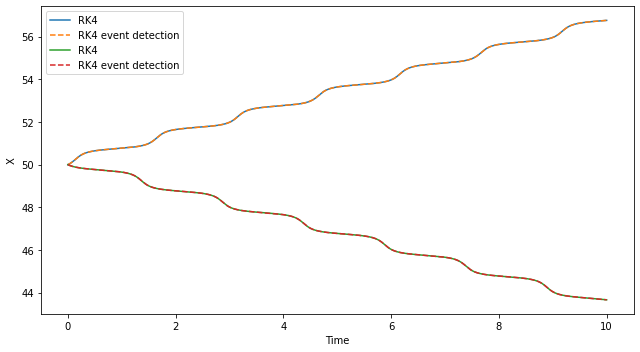

In [4]:
# Problem properties
X0 = 50
Tmax = 10
dt = 0.01

# Interpolation points
xc = np.linspace(0, 100, 1001)

# kind of interpolation
#kind = 'linear'
kind = 'quadratic'
#kind = 'cubic'


fig = plt.figure(figsize = (9, 5))

# Positive derivative
interpolator = interp1d(xc, 1.2 + np.sin(2*np.pi*xc), kind = kind)
f = lambda x, t: interpolator(x)
X_, T_ = trajectory_special(X0, Tmax, dt, f, rk4_dense, xc)
X, T = trajectory(X0, Tmax, dt, f, rk4)
plt.plot(T, X, label = 'RK4')
plt.plot(T_, X_, '--', label = 'RK4 event detection')

# Negative derivative
interpolator = interp1d(xc, -1.2 - np.sin(2*np.pi*xc), kind = kind)
f = lambda x, t: interpolator(x)
X_, T_ = trajectory_special(X0, Tmax, dt, f, rk4_dense, xc)
X, T = trajectory(X0, Tmax, dt, f, rk4)
plt.plot(T, X, label = 'RK4')
plt.plot(T_, X_, '--', label = 'RK4 event detection')

plt.xlabel('Time')
plt.ylabel('X')
plt.legend()
plt.tight_layout()

## Run convergence test

In [9]:
X0 = 0
Tmax = 10

# Interopolation points
xc = np.linspace(0, 100, 1001)

# kind of interpolation
kind = 'linear'
#kind = 'quadratic'
#kind = 'cubic'

# create interpolator, and wrap with lambda to get f(x, t)
interpolator = interp1d(xc, 2 + np.sin(2*np.pi*xc), kind = kind)
f = lambda x, t: interpolator(x)


# Reference solution
# (calculating the reference solution with the special integrator
# was found to work better)
dt_ref = 0.0002
X_ref_, T_ref = trajectory_special(X0, Tmax, dt_ref, f, rk4_dense, xc, progressbar = True)


# List of timesteps to investigate
dt_list = np.logspace(-3, -1, 100)

# Arrays to keep track of errors
errors = np.zeros(len(dt_list))
errors_special = np.zeros(len(dt_list))

# Loop over timesteps and calculate error
for i, dt in tqdm(enumerate(dt_list), total = len(dt_list)):
    X, T = trajectory(X0, Tmax, dt, f, rk4)
    errors[i] = np.abs(X_ref_[-1] - X[-1])
    X_, T_ = trajectory_special(X0, Tmax, dt, f, rk4_dense, xc)
    errors_special[i] = np.abs(X_ref_[-1] - X_[-1])

100%|██████████| 10.0/10 [00:05<00:00,  1.98it/s]               
100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


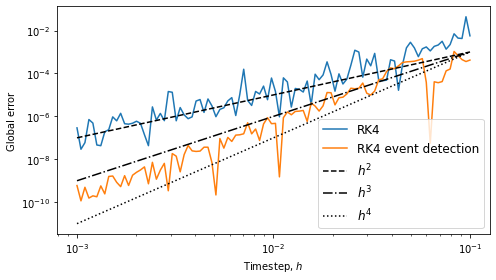

In [10]:
fig = plt.figure(figsize = (7, 4))

# Plot errors
plt.plot(dt_list, errors, label = 'RK4')
plt.plot(dt_list, errors_special, label = 'RK4 event detection')

# Plot trendlines
plt.plot(dt_list, 1e-1*dt_list**2, '--', c = 'k', label = '$h^2$')
plt.plot(dt_list, 1e-0*dt_list**3, '-.', c = 'k', label = '$h^3$')
plt.plot(dt_list, 1e+1*dt_list**4, ':',  c = 'k', label = '$h^4$')

# scales and labels, etc.
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Global error')
plt.xlabel('Timestep, $h$')
plt.legend(fontsize = 12, loc = 'lower right')
plt.tight_layout()